# WaveNet
WaveNet is a deep neural network architecture originally designed for audio that models sequential data using stacks of dilated causal convolutions, allowing it to capture long-range temporal dependencies with high efficiency.

## Step 1: Import Packages

In [1]:
#Note: The 3 Optimizations are marked with "Optimization:" in this code:
import pickle
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

## Step 2: Load preprocessed data

Loading all previously preprocessed and scaled datasets from a serialized pickle file.

In [2]:
with open("preprocessed_data.pkl", "rb") as f:
    data = pickle.load(f)

X_train = data["X_train"].values
X_val   = data["X_val"].values
X_test  = data["X_test"].values
y_train = data["y_train"]
y_val   = data["y_val"]
y_test  = data["y_test"]

## Step 3: Convert data into sequences

In [3]:
def create_sequences(X, y, seq_len=30):
    X_seq = []
    y_seq = []

    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])

    return np.array(X_seq), np.array(y_seq)



In [4]:
SEQ_LEN = 30  # window size

X_train_seq, y_train_seq = create_sequences(X_train, y_train, SEQ_LEN)
X_val_seq,   y_val_seq   = create_sequences(X_val, y_val, SEQ_LEN)
X_test_seq,  y_test_seq  = create_sequences(X_test, y_test, SEQ_LEN)

## Step 4: Build WaveNet-style model & Compile model

In [5]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[SEQ_LEN, X_train_seq.shape[2]]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(
        filters=32,
        kernel_size=2,
        padding="causal",
        activation="relu",
        dilation_rate=rate
    ))

model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

# Optimization 1: Instead of .flatten(), we used another pooling layer
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(1))

# Optimization 2: loss function:
# using keras.losses.Huber(delta=1.0) instead of "mse"
# using keras.optimizers.Adam(1e-3), instead of "adam"
model.compile(loss=keras.losses.Huber(delta=1.0),
              optimizer=keras.optimizers.Adam(1e-3),
              metrics=["mae"])


/home/daniel/.local/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


## Step 5: train the model

In [6]:
# Optimization 3 (Callback and more epochs; but with early stopping):
# Callback is added to avoid training a fixed amount of 20 epochs
cbs = [
  keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
  keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.5, min_lr=1e-6),
]


history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=200,# note the callback for early stopping!
    batch_size=64,
    callbacks = cbs
)


Epoch 1/200
15579/15579 ━━━━━━━━━━━━━━━━━━━━ 177s 11ms/step - loss: 0.0074 - mae: 0.0900 - val_loss: 0.0073 - val_mae: 0.0911 - learning_rate: 0.0010
Epoch 2/200
15579/15579 ━━━━━━━━━━━━━━━━━━━━ 168s 11ms/step - loss: 0.0057 - mae: 0.0774 - val_loss: 0.0054 - val_mae: 0.0770 - learning_rate: 0.0010
Epoch 3/200
15579/15579 ━━━━━━━━━━━━━━━━━━━━ 165s 11ms/step - loss: 0.0052 - mae: 0.0735 - val_loss: 0.0054 - val_mae: 0.0741 - learning_rate: 0.0010
Epoch 4/200
15579/15579 ━━━━━━━━━━━━━━━━━━━━ 165s 11ms/step - loss: 0.0049 - mae: 0.0709 - val_loss: 0.0056 - val_mae: 0.0754 - learning_rate: 0.0010
Epoch 5/200
15579/15579 ━━━━━━━━━━━━━━━━━━━━ 174s 11ms/step - loss: 0.0047 - mae: 0.0697 - val_loss: 0.0049 - val_mae: 0.0710 - learning_rate: 0.0010
Epoch 6/200
15579/15579 ━━━━━━━━━━━━━━━━━━━━ 175s 11ms/step - loss: 0.0045 - mae: 0.0683 - val_loss: 0.0052 - val_mae: 0.0726 - learning_rate: 0.0010
Epoch 7/200
15579/15579 ━━━━━━━━━━━━━━━━━━━━ 176s 11ms/step - loss: 0.0044 - mae: 0.0674 - val_loss:

## Step 6: Make predictions and compute RMSE

In [7]:
preds = model.predict(X_test_seq).flatten()
rmse = np.sqrt(mean_squared_error(y_test_seq, preds))

print(f"RMSE for WaveNet: {rmse:.4f}")


6676/6676 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step
RMSE for WaveNet: 0.0893


## Step 7: Plot predictions vs. true values

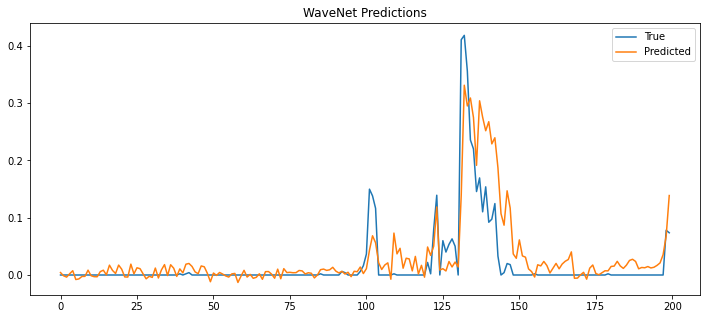

In [8]:
plt.figure(figsize=(12,5))
plt.plot(y_test_seq[:200], label="True")
plt.plot(preds[:200], label="Predicted")
plt.title("WaveNet Predictions")
plt.legend()
plt.show()